# <center>Visualize features maps and filters<center>


## Load libraries


In [29]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from PIL import Image
import json
%matplotlib inline

## Load image & pretrained model (resnet18)


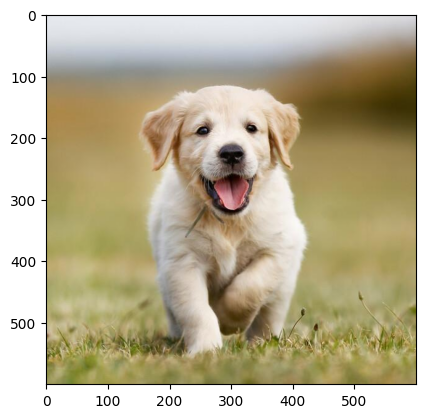

In [30]:
image = Image.open(str("dog.jpg"))
plt.imshow(image)

In [31]:
model = models.resnet18(weights=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/lore/Documents/GitHub/VisualIntelligence/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Extract the convolutional layers


In [32]:
# we will save the conv layer weights in this list
model_weights = []
# we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
# counter to keep count of the conv layers
counter = 0
# append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 17
conv_layers


In [33]:
# Load the model on GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
model = model.to(device)

In [34]:
# Resample the original image to 224x244
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.0, std=1.0),
    ]
)

image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


In [35]:
# process the images through all the convolutional layers
outputs = []
names = []
for layer in conv_layers[0:]:  # run over the convolutional layers
    image = layer(image)  # process the image
    outputs.append(image)  # save the output of the layer
    names.append(str(layer))  # save the name of the layer
print(len(outputs))

# print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

17
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])


In [36]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    # gray_scale = torch.sum(feature_map,0)
    f_map = feature_map
    break
    # gray_scale = gray_scale / feature_map.shape[0]
    # processed.append(gray_scale.data.cpu().numpy())
# for fm in processed:
#    print(fm.shape)

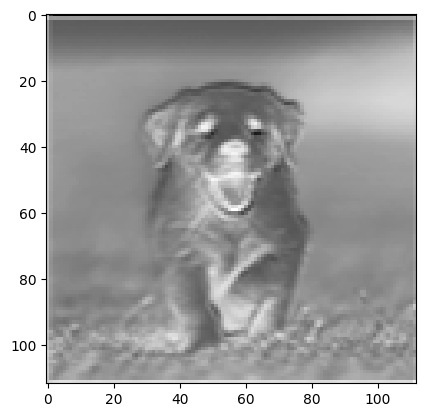

In [37]:
plt.imshow(f_map[46, :, :].cpu().detach().numpy(), cmap="Greys")

In [38]:
# Convert from 3D to 2D summing the element for each channel
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map, 0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(14, 14)
(14, 14)
(14, 14)
(14, 14)


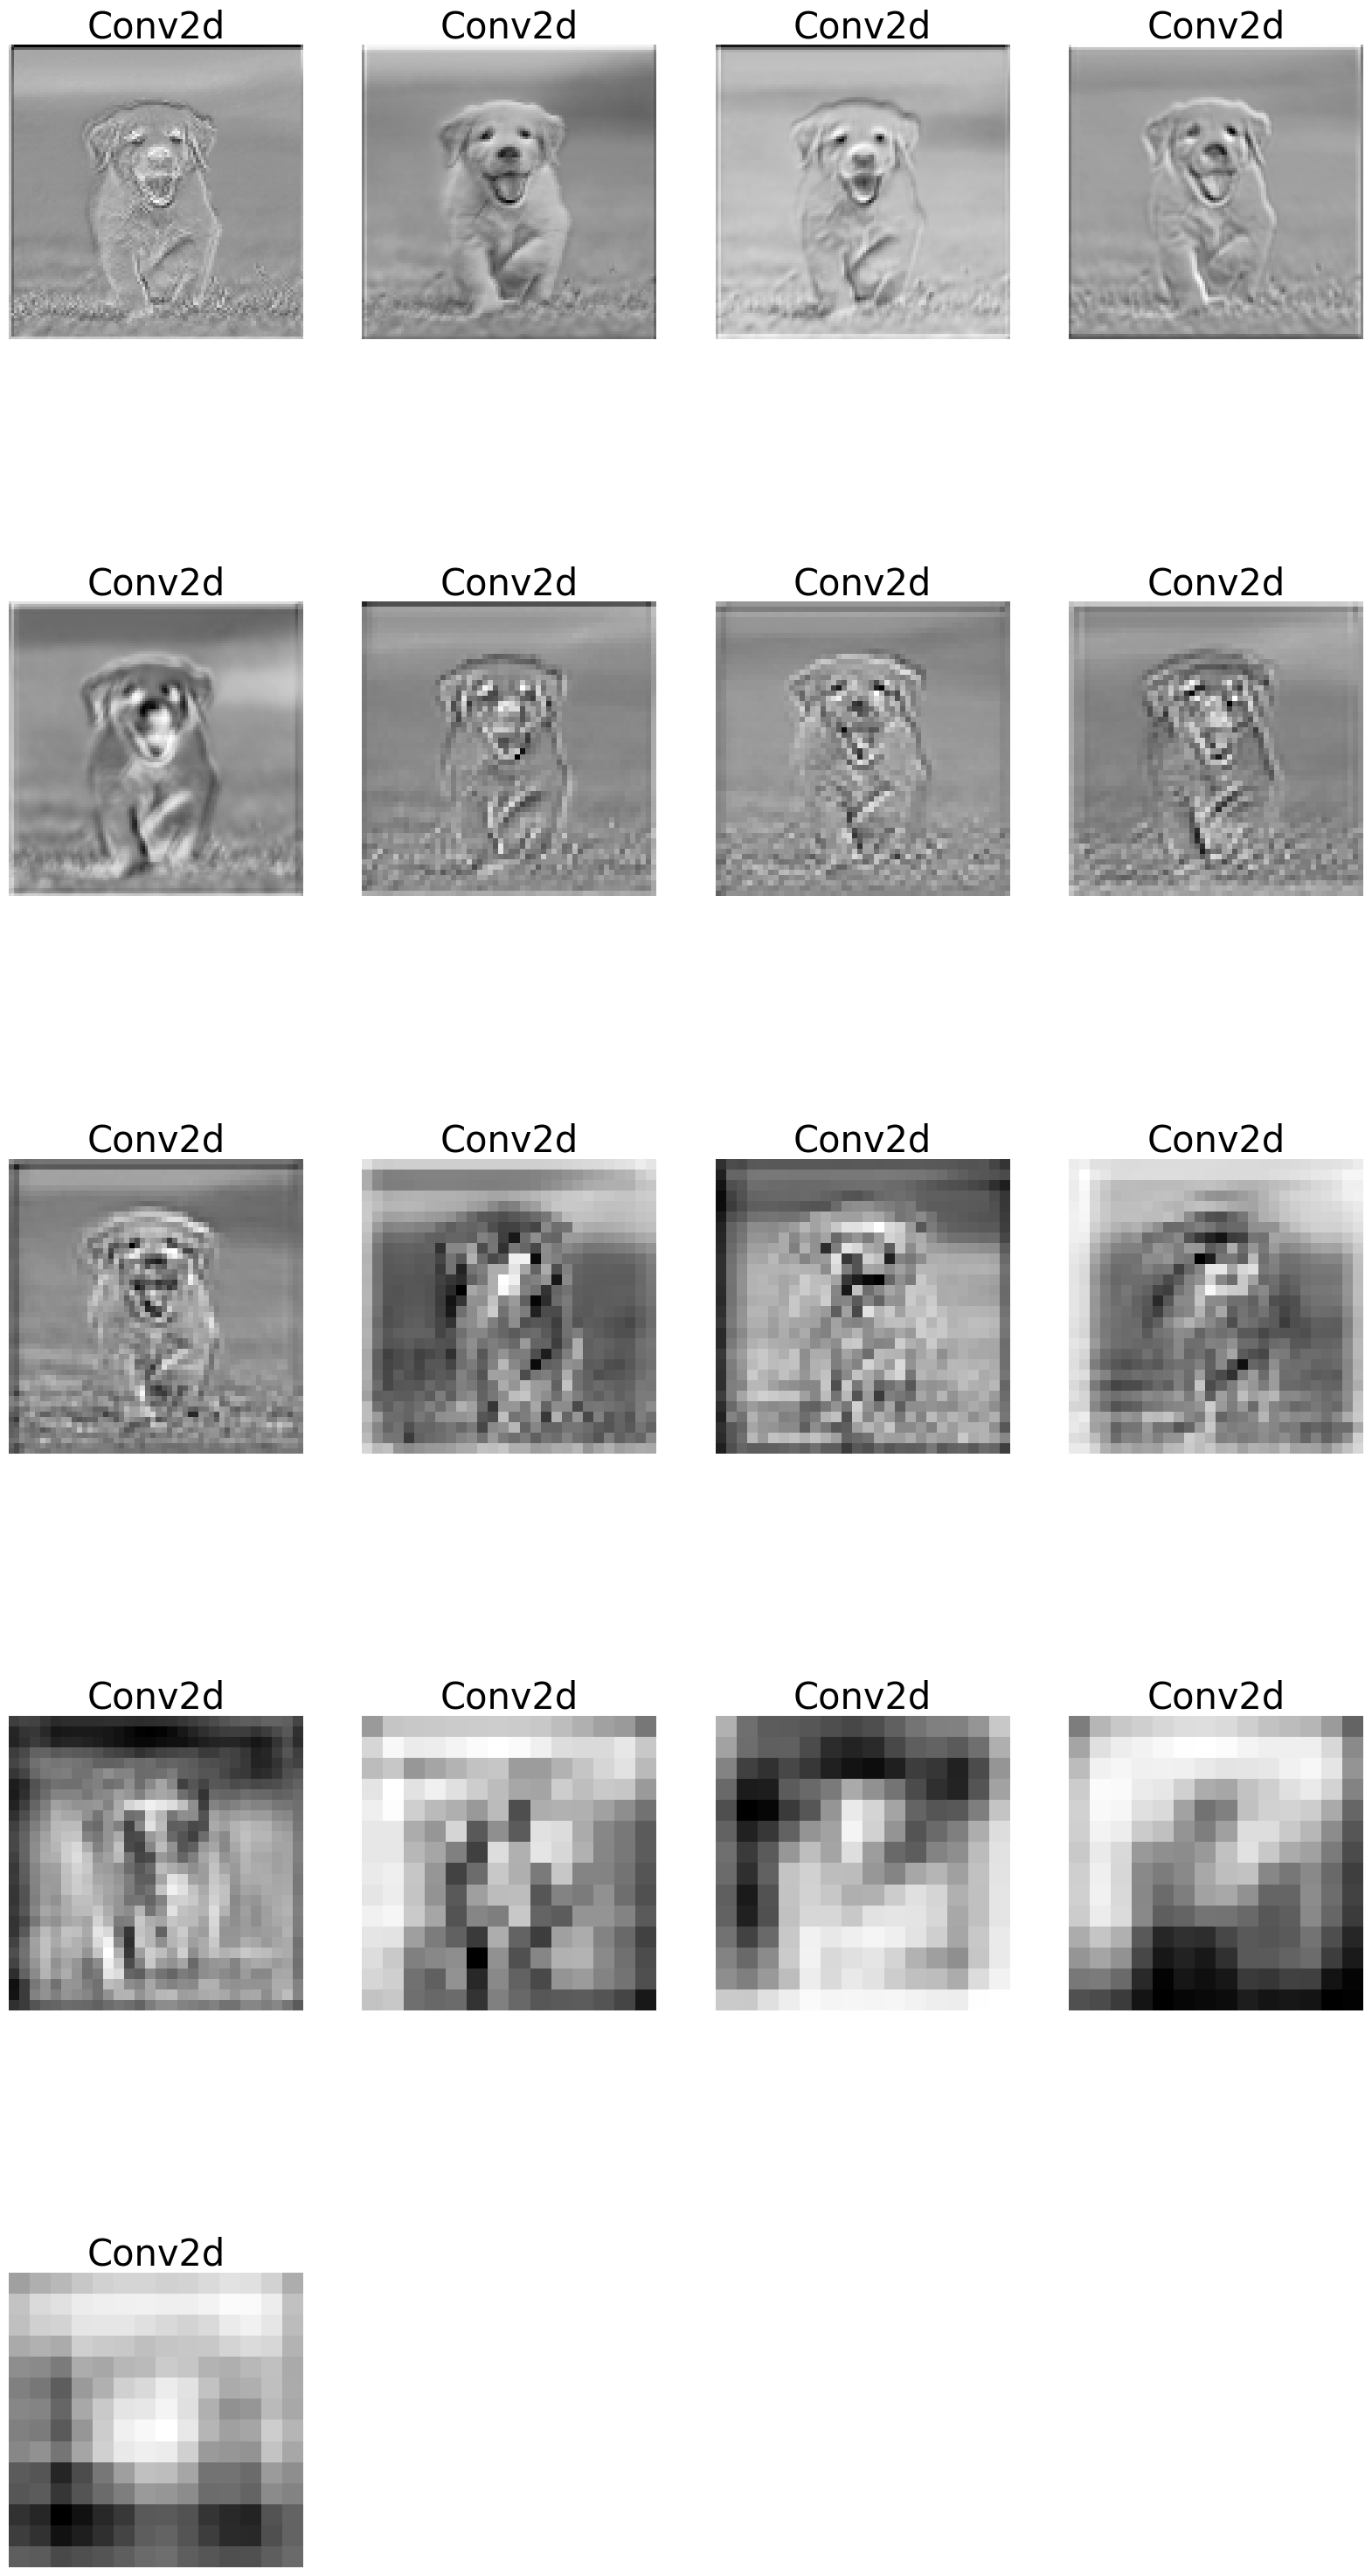

In [39]:
fig = plt.figure(figsize=(20, 40))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i + 1)
    imgplot = plt.imshow(processed[i], cmap="Greys")
    a.axis("off")
    a.set_title(names[i].split("(")[0], fontsize=30)

plt.show()

In [40]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
    n, c, w, h = tensor.shape

    if allkernels:
        tensor = tensor.view(n * c, -1, w, h)
    elif c != 3:
        tensor = tensor[:, ch, :, :].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure(figsize=(nrow, rows))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

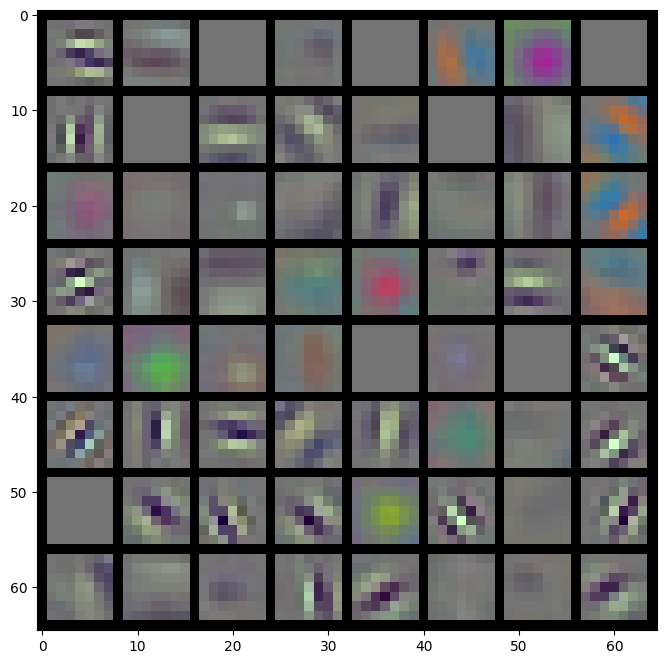

In [53]:
visTensor(model_weights[0],ch=0, allkernels=False)

In [42]:
def plot_filters_single_channel_big(t):

    # setting the rows and columns
    nrows = t.shape[0] * t.shape[2]
    ncols = t.shape[1] * t.shape[3]

    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)

    npimg = npimg.T

    fig, ax = plt.subplots(figsize=(ncols / 10, nrows / 200))
    imgplot = sns.heatmap(
        npimg, xticklabels=False, yticklabels=False, cmap="gray", ax=ax, cbar=False
    )


def plot_filters_single_channel(t):

    # kernels depth * number of kernels
    nplots = t.shape[0] * t.shape[1]
    ncols = 12

    nrows = 1 + nplots // ncols
    # convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)

    count = 0
    fig = plt.figure(figsize=(ncols, nrows))

    # looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg, cmap="Greys")
            ax1.set_title(str(i) + "," + str(j))
            ax1.axis("off")
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

    plt.tight_layout()
    plt.show()


def plot_filters_multi_channel(t):

    # get the number of kernals
    num_kernels = t.shape[0]

    # define number of columns for subplots
    num_cols = 12
    # rows = num of kernels
    num_rows = num_kernels

    # set the figure size
    fig = plt.figure(figsize=(num_cols, num_rows))

    # looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows, num_cols, i + 1)

        # for each kernel, we convert the tensor to numpy
        npimg = np.array(t[i].numpy(), np.float32)
        # standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg, cmap="Greys")
        ax1.axis("off")
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.savefig("myimage.png", dpi=100)
    plt.tight_layout()
    plt.show()


def plot_weights(model_layer, single_channel=True, collated=False):

    # extracting the model features at the particular layer number
    layer = model_layer

    # checking whether the layer is convolution layer or not

    # getting the weight tensor data
    weight_tensor = layer  # layer.weight.data.cpu()

    if single_channel:
        if collated:
            plot_filters_single_channel_big(weight_tensor)
        else:
            plot_filters_single_channel(weight_tensor)

    else:
        if weight_tensor.shape[1] == 3:
            plot_filters_multi_channel(weight_tensor)
        else:
            print(
                "Can only plot weights with three channels with single channel = False"
            )

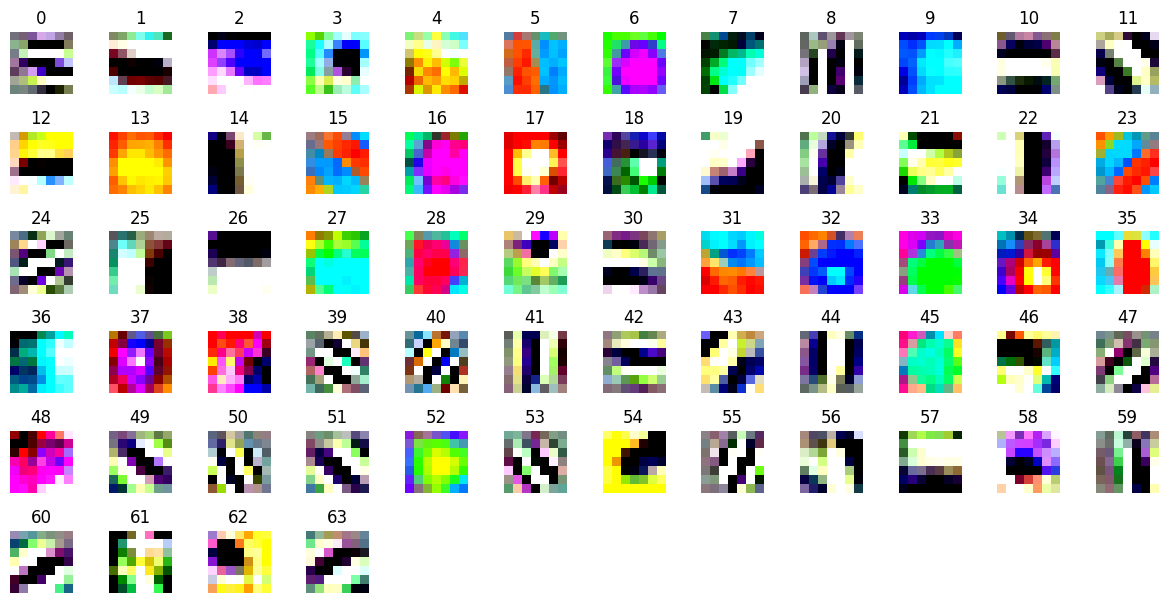

In [55]:
import seaborn as sns

plot_weights(model_weights[0].detach(), single_channel=False, collated=False)